In [ ]:
!pip install torchinfo

In [ ]:
# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image

# Preprocessing
from sklearn.model_selection import train_test_split as tts

# Torch
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchinfo import summary
from torchvision.models import vit_b_16, ViT_B_16_Weights

# Metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

# os
import os

# OrderedDict
from collections import OrderedDict

# tqdm
from tqdm.auto import tqdm

# Path
from pathlib import Path

# random
import random

# typing
from typing import Dict, List

# warnings
import warnings
warnings.filterwarnings("ignore")

In [ ]:
import kagglehub

# Download versi terbaru dari dataset
path = kagglehub.dataset_download("trainingdatapro/skin-defects-acne-redness-and-bags-under-the-eyes")

print("Path to dataset files:", path)


100%|██████████| 256M/256M [00:14<00:00, 18.4MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/trainingdatapro/skin-defects-acne-redness-and-bags-under-the-eyes/versions/1


In [ ]:
from pathlib import Path

# Tetapkan path dataset
IMAGE_PATH = Path("/root/.cache/kagglehub/datasets/trainingdatapro/skin-defects-acne-redness-and-bags-under-the-eyes/versions/1")

# Membuat list semua gambar
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("*/*/*/*.jpg"))

# Cetak total gambar
print(f'Total Images = {len(IMAGE_PATH_LIST)}')


Total Images = 87


In [ ]:
from pathlib import Path

# Tetapkan path dataset
IMAGE_PATH = Path("/root/.cache/kagglehub/datasets/trainingdatapro/skin-defects-acne-redness-and-bags-under-the-eyes/versions/1")

# Membuat list semua gambar (menggunakan pola glob rekursif)
IMAGE_PATH_LIST = list(IMAGE_PATH.glob("**/*.jpg"))

# Cetak total gambar
print(f'Total Images = {len(IMAGE_PATH_LIST)}')

# Daftar kelas (kelas berada di subfolder pada level kedua)
classes = sorted([p.name for p in IMAGE_PATH.glob("*/*") if p.is_dir()])

print("**" * 20)
print(f"Total Classes = {len(classes)}")
print("**" * 20)

# Cetak jumlah gambar per kelas
for c in classes:
    # Kelas mungkin berada lebih dalam, jadi kita sesuaikan path
    class_folders = list(IMAGE_PATH.glob(f"*/{c}"))  # Cari folder di dalam level kedua
    if not class_folders:
        print(f"Class folder for '{c}' not found.")
        continue  # Jika folder kelas tidak ditemukan, lanjut ke kelas berikutnya

    class_path = class_folders[0]  # Ambil folder pertama yang cocok

    # Debug: pastikan kita mencetak path yang benar
    print(f"Class path: {class_path}")

    # Mencari semua gambar di dalam subfolder kelas menggunakan pencarian rekursif (**) jika gambar ada lebih dalam
    total_images_class = list(class_path.glob("**/*.jpg"))

    # Debug: memastikan apakah gambar terbaca atau tidak
    if len(total_images_class) == 0:
        print(f"No images found for class: {c}")
    else:
        print(f"* {c}: {len(total_images_class)} images")


Total Images = 87
****************************************
Total Classes = 3
****************************************
Class path: /root/.cache/kagglehub/datasets/trainingdatapro/skin-defects-acne-redness-and-bags-under-the-eyes/versions/1/files/acne
* acne: 30 images
Class path: /root/.cache/kagglehub/datasets/trainingdatapro/skin-defects-acne-redness-and-bags-under-the-eyes/versions/1/files/bags
* bags: 27 images
Class path: /root/.cache/kagglehub/datasets/trainingdatapro/skin-defects-acne-redness-and-bags-under-the-eyes/versions/1/files/redness
* redness: 30 images


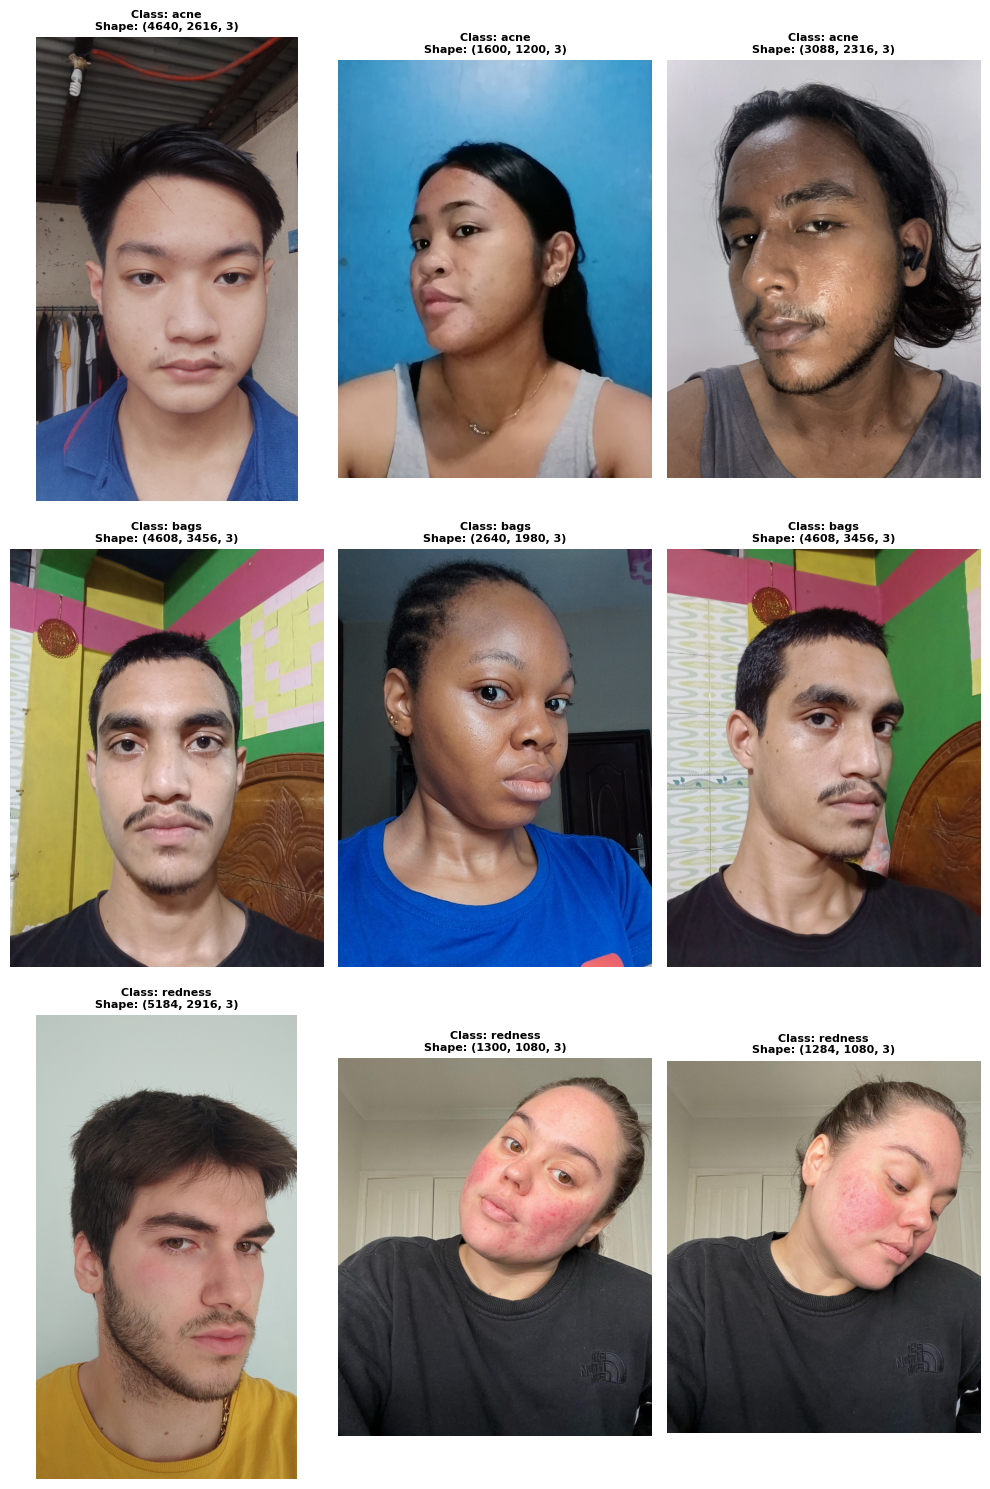

In [ ]:
import random
import cv2
import matplotlib.pyplot as plt
from pathlib import Path

# Tetapkan jumlah gambar yang ingin dilihat untuk setiap kelas
NUM_IMAGES = 3

# Buat plot dengan subplots sesuai dengan jumlah kelas dan gambar per kelas
fig, ax = plt.subplots(nrows=len(classes), ncols=NUM_IMAGES, figsize=(10, 15))

# Inisialisasi untuk penomoran baris subplot
p = 0

for c in classes:
    # Mencari folder kelas
    class_folders = list(IMAGE_PATH.glob(f"*/{c}"))
    if not class_folders:
        print(f"Class folder for '{c}' not found.")
        continue  # Jika folder kelas tidak ditemukan, lanjutkan ke kelas berikutnya

    class_path = class_folders[0]  # Gunakan folder pertama yang cocok

    # Mencari semua gambar di folder kelas menggunakan pola glob rekursif
    total_images_class = list(class_path.glob("**/*.jpg"))

    # Jika jumlah gambar lebih sedikit dari NUM_IMAGES, gunakan semua gambar yang tersedia
    if len(total_images_class) < NUM_IMAGES:
        images_selected = total_images_class
    else:
        images_selected = random.sample(total_images_class, k=NUM_IMAGES)

    for i, img_path in enumerate(images_selected):
        # Membaca gambar menggunakan OpenCV
        img_bgr = cv2.imread(str(img_path))

        # Pastikan gambar terbaca dengan benar
        if img_bgr is None:
            print(f"Failed to load image: {img_path}")
            continue

        # Konversi gambar dari BGR ke RGB (karena OpenCV membaca gambar dalam format BGR)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        # Menampilkan gambar di subplot
        ax[p, i].imshow(img_rgb)
        ax[p, i].axis("off")
        ax[p, i].set_title(f"Class: {c}\nShape: {img_rgb.shape}", fontsize=8, fontweight="bold", color="black")

    # Naikkan indeks untuk baris subplot berikutnya
    p += 1

# Mengatur tata letak subplot agar tidak tumpang tindih
fig.tight_layout()
plt.show()


In [ ]:
images_path = [None] * len(IMAGE_PATH_LIST)
labels = [None] * len(IMAGE_PATH_LIST)

for i,image_path in enumerate(IMAGE_PATH_LIST):
    images_path[i] = image_path
    labels[i] = image_path.parent.parent.stem

df_path_and_label = pd.DataFrame({'path':images_path,
                                  'label':labels})
df_path_and_label.head()

,path,label
0,/root/.cache/kagglehub/datasets/trainingdatapr...,redness
1,/root/.cache/kagglehub/datasets/trainingdatapr...,redness
2,/root/.cache/kagglehub/datasets/trainingdatapr...,redness
3,/root/.cache/kagglehub/datasets/trainingdatapr...,redness
4,/root/.cache/kagglehub/datasets/trainingdatapr...,redness


In [ ]:
SEED = 123

df_train, df_rest = tts(df_path_and_label,
                        test_size = 0.3,
                        random_state = SEED,
                        stratify = df_path_and_label["label"])

df_val, df_test = tts(df_rest,
                      test_size = 0.5,
                      random_state = SEED,
                      stratify = df_rest["label"])

In [ ]:
# We have to define the mapping of the classes to convert the labels to numbers.
label_map = dict(zip(classes, range(0, len(classes))))
label_map

{'acne': 0, 'bags': 1, 'redness': 2}

In [ ]:
from torchvision.models import vit_b_16, ViT_B_16_Weights
from torchvision import transforms

# Load pretrained ViT model weights
weights = ViT_B_16_Weights.DEFAULT

# Mengambil transformasi default dari model ViT
auto_transforms = weights.transforms()

# Cetak transformasi default yang digunakan oleh model ViT
print("Default Transformations from ViT_B_16_Weights:")
print(auto_transforms)

# Jika ingin membuat transformasi secara manual
manual_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalisasi manual
])

print("\nManual Transformations:")
print(manual_transforms)


Default Transformations from ViT_B_16_Weights:
ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

Manual Transformations:
Compose(
    Resize(size=256, interpolation=bilinear, max_size=None, antialias=True)
    CenterCrop(size=(224, 224))
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)


In [ ]:
class CustomDataset(Dataset):
    def __init__(self, df:pd.DataFrame, transforms, label_map:dict):
        self.df = df
        self.transforms = transforms
        self.label_map = label_map

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        df_new = self.df.copy()
        df_new = df_new.reset_index(drop = True)
        df_new["label"] = df_new["label"].map(self.label_map)
        image_path = df_new.iloc[idx, 0]
        image = Image.open(image_path).convert("RGB")
        image = self.transforms(image)
        label = df_new.iloc[idx, 1]

        return image,label

In [ ]:
train_dataset = CustomDataset(df_train, auto_transforms, label_map)
valid_dataset = CustomDataset(df_val, auto_transforms, label_map)

In [ ]:
BATCH_SIZE = 1
NUM_WORKERS = os.cpu_count()

train_dataloader = DataLoader(dataset = train_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)
valid_dataloader = DataLoader(dataset = valid_dataset,
                              batch_size = BATCH_SIZE,
                              shuffle = True,
                              num_workers = NUM_WORKERS)

In [ ]:
# Let's visualize the dimensions of a batch.
batch_images, batch_labels = next(iter(train_dataloader))
batch_images.shape, batch_labels.shape
(torch.Size([1, 3, 224, 224]), torch.Size([1]))

(torch.Size([1, 3, 224, 224]), torch.Size([1]))

In [ ]:
# GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
# We define the model to use with the pre-trained weights.
model = vit_b_16(weights = weights)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:01<00:00, 180MB/s]


In [ ]:
# Let's visualize the architecture of the model.
summary(model = model,
        input_size = [1, 3, 224, 224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             True
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] 590,592         True
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         True
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              True
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   7,087,872       True
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]   [1, 1

In [ ]:
for param in model.conv_proj.parameters():
    param.requires_grad = False

In [ ]:
for param in model.encoder.parameters():
    param.requires_grad = False

In [ ]:
# Let's see if the parameters were frozen.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 1000]       768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [ ]:
output_shape = len(classes)

model.heads = nn.Sequential(OrderedDict([('head', nn.Linear(in_features = 768,
                                                            out_features = output_shape))]))

In [ ]:
# One last time let's take a look if the last layer was modified.
summary(model = model,
        input_size = [1,3,224,224],
        col_names = ["input_size", "output_size", "num_params", "trainable"],
        col_width = 15,
        row_settings = ["var_names"])

Layer (type (var_name))                                      Input Shape     Output Shape    Param #         Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224] [1, 3]          768             Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224] [1, 768, 14, 14] (590,592)       False
├─Encoder (encoder)                                          [1, 197, 768]   [1, 197, 768]   151,296         False
│    └─Dropout (dropout)                                     [1, 197, 768]   [1, 197, 768]   --              --
│    └─Sequential (layers)                                   [1, 197, 768]   [1, 197, 768]   --              False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]   [1, 197, 768]   (7,087,872)     False
│    │    └─EncoderBlock (encoder_layer_2)                   [1, 197, 768]

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.01)

In [ ]:
def train_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module,
               optimizer:torch.optim.Optimizer):

    model.train()

    train_loss = 0.
    train_accuracy = 0.

    for batch,(X,y) in enumerate(dataloader):
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        y_pred_logit = model(X)
        loss = loss_fn(y_pred_logit, y)
        train_loss += loss.item()

        loss.backward()
        optimizer.step()

        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        train_accuracy += accuracy_score(y.cpu().numpy(),
                                         y_pred_class.detach().cpu().numpy())

    train_loss = train_loss/len(dataloader)
    train_accuracy = train_accuracy/len(dataloader)

    return train_loss, train_accuracy

In [ ]:
def save_checkpoint(filename, model, loss, epoch, optimizer, metric):
    state = {"filename":filename,
             "model":model.state_dict(),
             "loss":loss,
             "epoch":epoch,
             "optimizer":optimizer.state_dict(),
             "metric":metric}

    torch.save(state, filename)

In [ ]:
def valid_step(model:torch.nn.Module,
               dataloader:torch.utils.data.DataLoader,
               loss_fn:torch.nn.Module):

    model.eval()

    valid_loss = 0.
    valid_accuracy = 0.

    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device), y.to(device)
            y_pred_logit = model(X)
            loss = loss_fn(y_pred_logit, y)
            valid_loss += loss.item()

            y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
            y_pred_class = torch.argmax(y_pred_prob, dim = 1)

            valid_accuracy += accuracy_score(y.cpu().numpy(), y_pred_class.detach().cpu().numpy())

    valid_loss = valid_loss/len(dataloader)
    valid_accuracy = valid_accuracy/len(dataloader)

    return valid_loss, valid_accuracy

In [ ]:
def train(model:torch.nn.Module,
          train_dataloader:torch.utils.data.DataLoader,
          valid_dataloader:torch.utils.data.DataLoader,
          loss_fn:torch.nn.Module,
          optimizer:torch.optim.Optimizer,
          epochs:int = 10):

    results = {"train_loss":[],
               "train_accuracy":[],
               "valid_loss":[],
               "valid_accuracy":[]}

    best_valid_loss = float("inf")

    for epoch in tqdm(range(epochs)):
        train_loss, train_accuracy = train_step(model = model,
                                                dataloader = train_dataloader,
                                                loss_fn = loss_fn,
                                                optimizer = optimizer)

        valid_loss, valid_accuracy = valid_step(model = model,
                                                dataloader = valid_dataloader,
                                                loss_fn = loss_fn)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            file_name = "best_model.pth"
            save_checkpoint(file_name, model, best_valid_loss, epoch, optimizer, valid_accuracy)

        print(f"Epoch: {epoch + 1} | ",
              f"Train Loss: {train_loss:.4f} | ",
              f"Train Accuracy: {train_accuracy:.4f} | ",
              f"Valid Loss: {valid_loss:.4f} | ",
              f"Valid Accuracy: {valid_accuracy:.4f}")

        results["train_loss"].append(train_loss)
        results["train_accuracy"].append(train_accuracy)
        results["valid_loss"].append(valid_loss)
        results["valid_accuracy"].append(valid_accuracy)

    return results

In [ ]:
# Training!!!
EPOCHS = 100

torch.cuda.manual_seed(SEED)
torch.manual_seed(SEED)

MODEL_RESULTS = train(model.to(device),
                      train_dataloader,
                      valid_dataloader,
                      loss_fn,
                      optimizer,
                      EPOCHS)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch: 1 |  Train Loss: 2.1804 |  Train Accuracy: 0.4333 |  Valid Loss: 1.6055 |  Valid Accuracy: 0.3846
Epoch: 2 |  Train Loss: 2.3547 |  Train Accuracy: 0.5333 |  Valid Loss: 0.7802 |  Valid Accuracy: 0.7692
Epoch: 3 |  Train Loss: 1.2370 |  Train Accuracy: 0.7000 |  Valid Loss: 0.8841 |  Valid Accuracy: 0.6154
Epoch: 4 |  Train Loss: 0.8212 |  Train Accuracy: 0.7000 |  Valid Loss: 3.2707 |  Valid Accuracy: 0.4615
Epoch: 5 |  Train Loss: 0.3131 |  Train Accuracy: 0.9000 |  Valid Loss: 1.1169 |  Valid Accuracy: 0.6923
Epoch: 6 |  Train Loss: 0.0977 |  Train Accuracy: 0.9500 |  Valid Loss: 0.9242 |  Valid Accuracy: 0.6923
Epoch: 7 |  Train Loss: 0.0741 |  Train Accuracy: 0.9667 |  Valid Loss: 0.2504 |  Valid Accuracy: 0.8462
Epoch: 8 |  Train Loss: 0.1026 |  Train Accuracy: 0.9500 |  Valid Loss: 0.3934 |  Valid Accuracy: 0.9231
Epoch: 9 |  Train Loss: 0.2444 |  Train Accuracy: 0.8833 |  Valid Loss: 2.3341 |  Valid Accuracy: 0.6923
Epoch: 10 |  Train Loss: 0.5818 |  Train Accuracy: 0.93

In [ ]:
# Function to plot the loss and metric during each training epoch.
def loss_metric_curve_plot(model_results:Dict[str,List[float]]):

    train_loss = model_results["train_loss"]
    valid_loss = model_results["valid_loss"]

    train_accuracy = [float(value) for value in model_results["train_accuracy"]]
    valid_accuracy = [float(value) for value in model_results["valid_accuracy"]]

    fig,axes = plt.subplots(nrows = 1, ncols = 2, figsize = (10,4))
    axes = axes.flat

    axes[0].plot(train_loss, color = "red", label = "Train")
    axes[0].plot(valid_loss, color = "blue", label = "Valid")
    axes[0].set_title("CrossEntropyLoss", fontsize = 12, fontweight = "bold", color = "black")
    axes[0].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].set_ylabel("Loss", fontsize = 10, fontweight = "bold", color = "black")
    axes[0].legend()

    axes[1].plot(train_accuracy, color = "red", label = "Train")
    axes[1].plot(valid_accuracy, color = "blue", label = "Valid")
    axes[1].set_title("Metric of performance: Accuracy", fontsize = 12, fontweight = "bold", color = "black")
    axes[1].set_xlabel("Epochs", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].set_ylabel("Score", fontsize = 10, fontweight = "bold", color = "black")
    axes[1].legend()

    fig.tight_layout()
    fig.show()

    # Mengembalikan akurasi pelatihan dan validasi pada epoch terakhir
    final_train_accuracy = train_accuracy[-1] * 100
    final_valid_accuracy = valid_accuracy[-1] * 100
    print(f"Final Train Accuracy: {final_train_accuracy:.2f}%")
    print(f"Final Validation Accuracy: {final_valid_accuracy:.2f}%")

    return final_train_accuracy, final_valid_accuracy

Final Train Accuracy: 100.00%
Final Validation Accuracy: 92.31%


(100.0, 92.3076923076923)

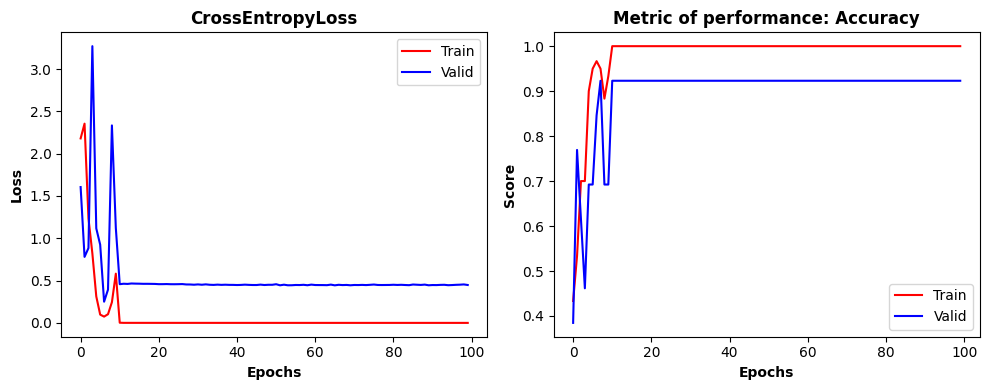

In [ ]:
loss_metric_curve_plot(MODEL_RESULTS)

In [ ]:
# Step 1: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Step 2: Load the model
import torch

# Ganti dengan path file model Anda di Google Drive
checkpoint_path = '/content/drive/My Drive/stki/best_model.pth'
checkpoint = torch.load(checkpoint_path)

# Melanjutkan dengan proses lain jika diperlukan


Mounted at /content/drive


In [ ]:
# Now let's look at the smallest loss, its metric and when it occurred.
print(f'Best Loss: {checkpoint["loss"]}')
print(f'Epoch: {checkpoint["epoch"] + 1}')
print(f'Best Metric: {checkpoint["metric"]}')

Best Loss: 0.2745389061203521
Epoch: 100
Best Metric: 0.9230769230769231


In [ ]:
# First of all, we create the Dataset, DataLoader
test_dataset = CustomDataset(df_test, auto_transforms, label_map)
test_dataloader = DataLoader(dataset = test_dataset, shuffle = False, num_workers = NUM_WORKERS)

In [ ]:
# We define the model again with its respective modification.
loaded_model = vit_b_16()

loaded_model.heads = nn.Sequential(OrderedDict([('head',nn.Linear(in_features = 768,
                                                                  out_features = output_shape))]))

loaded_model.load_state_dict(checkpoint["model"])

# We now infer
loaded_model.to(device)

loaded_model.eval()

y_pred_test = []

with torch.inference_mode():
    for X,y in tqdm(test_dataloader):
        X,y = X.to(device), y.to(device)
        y_pred_logit = loaded_model(X)
        y_pred_prob = torch.softmax(y_pred_logit, dim = 1)
        y_pred_class = torch.argmax(y_pred_prob, dim = 1)
        y_pred_test.append(y_pred_class.detach().cpu())

  0%|          | 0/14 [00:00<?, ?it/s]

In [ ]:
y_pred_test = torch.cat(y_pred_test).numpy()

In [ ]:
print(f'Accuracy = {round(accuracy_score(df_test["label"].map(label_map), y_pred_test), 4)}')

Accuracy = 0.7857
